# Counterfactual Analysis of Target Temperature Management (TTM) Protocols

## Introduction
This notebook explores the impact of different Target Temperature Management (TTM) protocols on patient outcomes, with the aim of identifying optimal treatments for specific patient subpopulations. By evaluating counterfactual scenarios, we assess how changes in TTM protocols—specifically, TTM at 33°C, TTM at 36°C, and no TTM—affect the model's predictions for each patient. Through this analysis, we aim to:
- Determine the best predicted outcome per patient under each TTM protocol.
- Identify distinct patient groups that benefit most from TTM 33, TTM 36, or no TTM.
- Evaluate if the changes are statistically significant between original and counterfactual groups.
- Explore shared characteristics within each group to better understand optimal TTM conditions.

## Table of Contents
1. [Setup & Imports](#setup-imports)
2. [Data Loading and Preparation](#data-loading-preparation)
3. [Define Counterfactual Scenarios for TTM Protocols](#define-counterfactual-scenarios)
4. [Generate and Compare Predictions for Each Protocol](#generate-and-compare-predictions)
5. [Group Patients by Optimal Protocol](#group-patients-by-optimal-protocol)
6. [Significance Testing of Prediction Changes](#significance-testing)
7. [Analysis of Commonalities Within Each Group](#group-commonalities-analysis)

---

Each section provides a step-by-step approach to answer our main questions and assess the impact of different TTM protocols on patient outcomes. By the end of this notebook, we will gain insights into which TTM protocol is most beneficial for distinct patient groups and identify key characteristics that define these groups.


## 1. Setup & Imports <a id="setup-imports"></a>

In this section, we import the necessary libraries for data manipulation, model prediction, statistical testing, and visualization. These libraries will enable us to efficiently load, process, and analyze data, as well as interpret model outputs.

- **NumPy and Pandas**: Essential for data handling and manipulation.
- **TensorFlow**: Used to load and work with the neural network model for generating predictions under different TTM protocols.
- **sklearn**: Provides metrics for evaluating model performance.
- **scipy.stats**: Useful for conducting statistical tests to evaluate the significance of prediction changes.
- **SHAP**: Helps interpret model predictions, which is useful in analyzing the feature contributions for different TTM protocols.
- **Matplotlib and Seaborn**: Visualization libraries for creating insightful plots.

[Back to Table of Contents](#table-of-contents)

In [1]:
# Setup & Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
import pickle

# Set up visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Training will use the CPU.")


GPU is not available. Training will use the CPU.


## 2. Data Loading and Preparation <a id="data-loading-preparation"></a>

Here, we load the preprocessed datasets required for counterfactual analysis. The data includes:
- **machine_learning_patient_data**: Contains patient data already prepared for model predictions.
- **ecg_data**: Features specific to ECG measurements.
- **patient_data**: Contains target outcome values mapped as 1 for "Good" and 0 for "Poor".

These datasets will be merged and combined to create a single DataFrame for analysis. Additionally, time-series features are reshaped to match the model's input format.

[Back to Table of Contents](#table-of-contents)


In [2]:
# Loading the dataset that has been fully prepared for distance-based prediction
with open('data/machine_learning_patient_data.pkl', 'rb') as f:
    machine_learning_patient_data = pickle.load(f)

# Load ECG data
ecg_data = pd.read_csv('data/ecg_data.csv')

# Loading the dataset that has the target value and original features and values
with open('data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

# Map 'Good' to 1 and 'Poor' to 0 for target outcome
patient_data['outcome'] = patient_data['outcome'].map({'Good': 1, 'Poor': 0}).astype(int)

# Step 1: Merge machine_learning_patient_data and ecg_data on patient identifiers
combined_data = pd.merge(
    machine_learning_patient_data, ecg_data, 
    left_on='Patient', right_on='Patient_ID', 
    how='inner'
)

# Step 2: Merge the resulting combined_data with patient_data to add the 'outcome' column
combined_data = pd.merge(
    combined_data, patient_data[['Patient', 'outcome']], 
    on='Patient', 
    how='inner'
)

# Display the first few rows of the combined DataFrame to verify
combined_data.head()


,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,...,Segment_287_HRV_SDNN,Segment_287_LF_Power,Segment_287_HF_Power,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_Power,Segment_288_HF_Power,Segment_288_LF_HF_Ratio,outcome
0,284,-0.522787,False,True,True,False,True,False,False,False,...,0.981133,-0.093946,-0.088465,-0.096152,0.344520,1.128406,-0.063206,-0.062188,-0.238693,1
1,286,1.525272,True,False,False,False,False,False,True,True,...,1.816490,-0.073634,-0.100386,-0.059189,0.482280,0.000000,-0.061845,-0.061378,-0.176915,1
2,296,-0.842797,False,True,True,False,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,299,-1.034802,False,True,True,False,True,False,False,False,...,2.456931,-0.111831,-0.085917,-0.109046,-0.516477,0.501520,-0.063652,-0.062835,-0.192359,1
4,303,-0.650791,False,True,True,False,True,False,False,False,...,-0.759196,-0.182218,-0.129349,-0.121940,-1.170835,0.002860,-0.063798,-0.062743,-0.303560,1


## 3. Define Counterfactual Scenarios for TTM Protocols <a id="define-counterfactual-scenarios"></a>

In this section, we define counterfactual scenarios to evaluate how each TTM protocol (TTM 33, TTM 36, and No TTM) affects patient outcomes. For each patient, we will create variations with each TTM protocol and then generate predictions based on these alternative treatments.

Steps:
1. **Set Up Counterfactual Treatments**: Define TTM 33, TTM 36, and No TTM variations for each patient.
2. **Generate Predictions for Each Protocol**: Use the trained model to predict outcomes for each TTM scenario.
3. **Prepare Data for Comparison**: Organize the predictions to allow easy comparison between the different TTM protocols.

[Back to Table of Contents](#table-of-contents)


In [3]:
tabular_cols = [
    'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_Unknown',
    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False',
    'shockable_rhythm_True', 'shockable_rhythm_Unknown', 'rosc'
]

# Identify time-series columns for the selected features
selected_time_series_cols = [col for col in combined_data.columns if 
                             any(feature in col for feature in ["Mean_HR", "HRV_SDNN", "LF_HF_Ratio"])]

# Reshape the time-series data into (samples, time steps, features)
X_time_series = combined_data[selected_time_series_cols].values.reshape(
    len(combined_data),  # samples (number of patients)
    -1,                  # time steps (number of segments per patient)
    3                    # features (3 values per time point: Mean_HR, HRV_SDNN, LF_HF_Ratio)
)

X_time_series.shape

(607, 288, 3)

In [4]:
# Load the model from models/neural_network.keras
best_model = load_model('models/neural_network.keras')

# Helper function to set TTM protocol and generate predictions
def generate_predictions_for_ttm(ttm_value, combined_data, model):
    # Make a copy of the data to avoid altering the original DataFrame
    data_copy = combined_data.copy()
    
    # Set TTM protocol columns based on the specified ttm_value
    if ttm_value == '33':
        data_copy['ttm_33.0'] = 1
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == '36':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 1
        data_copy['ttm_No TTM'] = 0
    elif ttm_value == 'No TTM':
        data_copy['ttm_33.0'] = 0
        data_copy['ttm_36.0'] = 0
        data_copy['ttm_No TTM'] = 1
    
    # Extract tabular and time-series data with proper shape
    tabular_input = data_copy[tabular_cols].values.astype('float32')
    time_series_input = data_copy[selected_time_series_cols].values.astype('float32').reshape(len(data_copy), 288, 3)
    
    # Generate predictions
    predictions = model.predict([tabular_input, time_series_input])
    return predictions

# Function to determine the original TTM protocol based on the columns
def get_original_ttm_protocol(row):
    if row['ttm_33.0'] == 1:
        return '33'
    elif row['ttm_36.0'] == 1:
        return '36'
    elif row['ttm_No TTM'] == 1:
        return 'No TTM'
    return 'Unknown'

# Add original TTM protocol column to the combined_data DataFrame
combined_data['Original_TTM'] = combined_data.apply(get_original_ttm_protocol, axis=1)

# Generate predictions for each TTM protocol
predictions_ttm_33 = generate_predictions_for_ttm('33', combined_data, best_model)
predictions_ttm_36 = generate_predictions_for_ttm('36', combined_data, best_model)
predictions_no_ttm = generate_predictions_for_ttm('No TTM', combined_data, best_model)

# Combine predictions into a DataFrame for easy comparison
ttm_predictions_df = pd.DataFrame({
    'Patient': combined_data['Patient'],
    'Original_TTM': combined_data['Original_TTM'],
    'Outcome': combined_data['outcome'],
    'Pred_TTM_33': predictions_ttm_33.flatten(),
    'Pred_TTM_36': predictions_ttm_36.flatten(),
    'Pred_No_TTM': predictions_no_ttm.flatten()
})

# Display 20 random samples from the predictions DataFrame
ttm_predictions_df.sample(20, random_state=42)



c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['tabular_input', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


,Patient,Original_TTM,Outcome,Pred_TTM_33,Pred_TTM_36,Pred_No_TTM
563,970,33,0,0.519208,0.519119,0.533490
289,655,33,0,0.593681,0.587946,0.593627
76,406,36,0,0.589975,0.552358,0.584292
78,409,33,0,0.481568,0.514257,0.512330
182,529,36,0,0.524780,0.523994,0.513721
495,890,33,0,0.462534,0.489999,0.502369
10,319,33,1,0.522154,0.498199,0.507243
131,465,No TTM,0,0.525421,0.485569,0.516957
445,835,33,1,0.477855,0.495791,0.504191
86,417,33,0,0.525144,0.526891,0.523006


In [5]:
# Define the threshold for considering predictions as "Same"
threshold = 0.02

# Function to assess each prediction against the original outcome with debug information
def assess_prediction(row, original_protocol, protocol_prediction, protocol_name):
    # Select the original prediction value based on the original TTM protocol
    if original_protocol == '33':
        original_prediction = row['Pred_TTM_33']
    elif original_protocol == '36':
        original_prediction = row['Pred_TTM_36']
    elif original_protocol == 'No TTM':
        original_prediction = row['Pred_No_TTM']
    else:
        return "Unknown Original TTM"

    if original_protocol == protocol_name:
        return "Original TTM"
    
    # Calculate the difference and check with threshold
    diff = protocol_prediction - original_prediction
    #print(f"Original protocol: {original_protocol}, Original value: {original_prediction}, "
    #      f"{protocol_name} is {protocol_prediction}, Difference: {abs(diff)}")
    
    if abs(diff) <= threshold:
        return "Same"
    elif diff > 0:
        return "Higher"
    else:
        return "Lower"

# Add assessment columns for each TTM protocol with the corrected original value
ttm_predictions_df['TTM_33_Asses'] = ttm_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['Pred_TTM_33'], '33'), axis=1
)
ttm_predictions_df['TTM_36_Asses'] = ttm_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['Pred_TTM_36'], '36'), axis=1
)
ttm_predictions_df['No_TTM_Asses'] = ttm_predictions_df.apply(
    lambda row: assess_prediction(row, row['Original_TTM'], row['Pred_No_TTM'], 'No TTM'), axis=1
)

# Define color mapping function for assessments
def color_assessment(val):
    if val == "Lower":
        return "background-color: lightcoral"
    elif val == "Higher":
        return "background-color: lightgreen"
    elif val == "Same":
        return "background-color: lightyellow"
    elif val == "Original TTM":
        return "background-color: lightblue"
    return ""

# Display the DataFrame with conditional formatting
# Selecting relevant columns and applying color to assessment columns
ttm_predictions_df[['Patient', 'Outcome', 'Original_TTM', 
                    'Pred_TTM_33', 'TTM_33_Asses', 
                    'Pred_TTM_36', 'TTM_36_Asses', 
                    'Pred_No_TTM', 'No_TTM_Asses']].sample(20, random_state=42)\
    .style.map(color_assessment, subset=['TTM_33_Asses', 'TTM_36_Asses', 'No_TTM_Asses'])


,Patient,Outcome,Original_TTM,Pred_TTM_33,TTM_33_Asses,Pred_TTM_36,TTM_36_Asses,Pred_No_TTM,No_TTM_Asses
563,970,0,33,0.519208,Original TTM,0.519119,Same,0.533490,Same
289,655,0,33,0.593681,Original TTM,0.587946,Same,0.593627,Same
76,406,0,36,0.589975,Higher,0.552358,Original TTM,0.584292,Higher
78,409,0,33,0.481568,Original TTM,0.514257,Higher,0.512330,Higher
182,529,0,36,0.524780,Same,0.523994,Original TTM,0.513721,Same
495,890,0,33,0.462534,Original TTM,0.489999,Higher,0.502369,Higher
10,319,1,33,0.522154,Original TTM,0.498199,Lower,0.507243,Same
131,465,0,No TTM,0.525421,Same,0.485569,Lower,0.516957,Original TTM
445,835,1,33,0.477855,Original TTM,0.495791,Same,0.504191,Higher
86,417,0,33,0.525144,Original TTM,0.526891,Same,0.523006,Same


In [6]:
def determine_best_prediction(row):
    # Extract the predictions for each protocol
    ttm_predictions = {
        '33': row['Pred_TTM_33'],
        '36': row['Pred_TTM_36'],
        'No TTM': row['Pred_No_TTM']
    }
    
    # Get the baseline prediction value based on Original_TTM
    original_protocol = row['Original_TTM']
    baseline_prediction = ttm_predictions[original_protocol]
    
    # Initialize the best protocol as the original
    best_protocol = original_protocol
    best_prediction = baseline_prediction
    
    # Check if any other protocol exceeds the baseline by the threshold
    for protocol, prediction in ttm_predictions.items():
        if protocol != original_protocol and prediction > baseline_prediction + threshold:
            best_protocol = protocol
            best_prediction = prediction
    
    return best_protocol

# Apply the function to determine the best protocol for each patient
ttm_predictions_df['Best_Prediction'] = ttm_predictions_df.apply(determine_best_prediction, axis=1)

ttm_predictions_df[['Patient', 'Outcome', 'Original_TTM', 'Best_Prediction', 
                    'Pred_TTM_33', 'TTM_33_Asses', 
                    'Pred_TTM_36', 'TTM_36_Asses', 
                    'Pred_No_TTM', 'No_TTM_Asses']].sample(20, random_state=42)\
    .style.map(color_assessment, subset=['TTM_33_Asses', 'TTM_36_Asses', 'No_TTM_Asses'])

,Patient,Outcome,Original_TTM,Best_Prediction,Pred_TTM_33,TTM_33_Asses,Pred_TTM_36,TTM_36_Asses,Pred_No_TTM,No_TTM_Asses
563,970,0,33,33,0.519208,Original TTM,0.519119,Same,0.533490,Same
289,655,0,33,33,0.593681,Original TTM,0.587946,Same,0.593627,Same
76,406,0,36,No TTM,0.589975,Higher,0.552358,Original TTM,0.584292,Higher
78,409,0,33,No TTM,0.481568,Original TTM,0.514257,Higher,0.512330,Higher
182,529,0,36,36,0.524780,Same,0.523994,Original TTM,0.513721,Same
495,890,0,33,No TTM,0.462534,Original TTM,0.489999,Higher,0.502369,Higher
10,319,1,33,33,0.522154,Original TTM,0.498199,Lower,0.507243,Same
131,465,0,No TTM,No TTM,0.525421,Same,0.485569,Lower,0.516957,Original TTM
445,835,1,33,No TTM,0.477855,Original TTM,0.495791,Same,0.504191,Higher
86,417,0,33,33,0.525144,Original TTM,0.526891,Same,0.523006,Same


In [7]:
# Count the transitions from Original_TTM to Best_Prediction
sankey_data = ttm_predictions_df.groupby(['Original_TTM', 'Best_Prediction']).size().reset_index(name='count')

# Calculate total patients in each Original_TTM group
group_totals = sankey_data.groupby('Original_TTM')['count'].transform('sum')

# Calculate percentage within each Original_TTM group
sankey_data['percentage'] = (sankey_data['count'] / group_totals * 100).round(1)

# Define unique nodes for original and best protocols
original_nodes = [f"Original {protocol}" for protocol in sankey_data['Original_TTM'].unique()]
best_nodes = [f"Best {protocol}" for protocol in sankey_data['Best_Prediction'].unique()]
nodes = original_nodes + best_nodes

# Map each node to a unique index for Sankey
node_map = {node: i for i, node in enumerate(nodes)}

# Define the sources, targets, values, and labels for the Sankey diagram
sankey_data['source'] = sankey_data['Original_TTM'].map(lambda x: node_map[f"Original {x}"])
sankey_data['target'] = sankey_data['Best_Prediction'].map(lambda x: node_map[f"Best {x}"])
sources = sankey_data['source'].tolist()
targets = sankey_data['target'].tolist()
values = sankey_data['count'].tolist()

# Use the group percentage labels for each link
labels = [f"{percentage}%" for percentage in sankey_data['percentage']]

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
    ),
    link=dict(
        source=sources,  # Indices of source nodes
        target=targets,  # Indices of target nodes
        value=values,    # Flow values between nodes
        label=labels     # Group percentage labels on each link
    )
))

# Add title and display
fig.update_layout(title_text="Sankey Diagram of TTM Protocol Changes (Original to Best Prediction)", font_size=12)
fig.show()


In [8]:
# Create a pivot table to show counts of transitions from Original_TTM to Best_Prediction
sankey_matrix = sankey_data.pivot(index='Original_TTM', columns='Best_Prediction', values='count').fillna(0)

# Calculate row-wise percentages to get the percentage of each original protocol going to each best protocol
sankey_percentage_matrix = sankey_matrix.div(sankey_matrix.sum(axis=1), axis=0) * 100

# Format as percentage with one decimal place
sankey_percentage_matrix = sankey_percentage_matrix.round(1).astype(str) + '%'

# Display the percentage matrix
sankey_percentage_matrix


Best_Prediction,33,36,No TTM
Original_TTM,,,
33,73.4%,0.7%,25.9%
36,27.9%,44.3%,27.9%
No TTM,9.2%,0.0%,90.8%


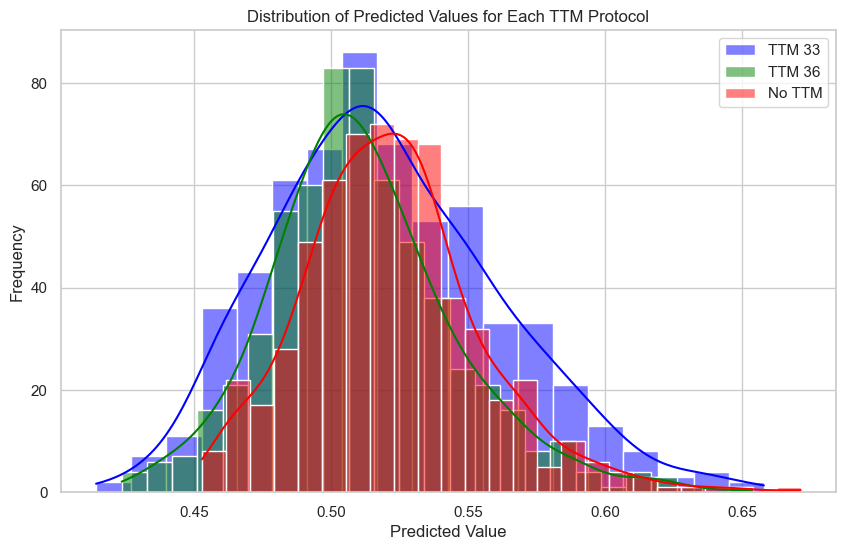

In [9]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the distribution for each protocol's predictions
sns.histplot(ttm_predictions_df['Pred_TTM_33'], color="blue", label="TTM 33", kde=True)
sns.histplot(ttm_predictions_df['Pred_TTM_36'], color="green", label="TTM 36", kde=True)
sns.histplot(ttm_predictions_df['Pred_No_TTM'], color="red", label="No TTM", kde=True)

# Add title and labels
plt.title("Distribution of Predicted Values for Each TTM Protocol")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()

# Show plot
plt.show()


In [10]:
# Filter patients where Best_Prediction differs from Original_TTM
changed_protocol_df = ttm_predictions_df[ttm_predictions_df['Best_Prediction'] != ttm_predictions_df['Original_TTM']]


In [11]:
import pandas as pd

# List of numerical and categorical columns based on `patient_data`
numerical_cols = ['age', 'rosc']
categorical_cols = ['sex', 'ohca', 'ttm', 'shockable_rhythm']

# Ensure `changed_protocol_original` is defined by merging `ttm_predictions_df` with `patient_data`
changed_protocol_original = changed_protocol_df.merge(
    patient_data[['Patient'] + numerical_cols + categorical_cols],
    on='Patient',
    suffixes=('_standardized', '_original')
)

# Dictionary to store results for each transition type
results = {}

# List of protocol transitions to analyze
transitions = [
    ('33', '36'),
    ('36', '33'),
    ('33', 'No TTM'),
    ('36', 'No TTM'),
    ('No TTM', '33'),
    ('No TTM', '36')
]

# Calculate means/modes for each specific transition type using original values
for original, best in transitions:
    # Filter for the specific transition
    transition_df = changed_protocol_original[
        (changed_protocol_original['Original_TTM'] == original) &
        (changed_protocol_original['Best_Prediction'] == best)
    ]
    
    # Calculate mean values for numerical features
    feature_means_original = transition_df[numerical_cols].mean()
    
    # Calculate mode for categorical features
    feature_modes_original = transition_df[categorical_cols].mode().iloc[0] if not transition_df.empty else pd.Series(dtype='object')
    
    # Count of cases for this transition
    num_cases = len(transition_df)
    
    # Add the count of cases as the first row in the result
    combined_features = pd.concat([pd.Series({'Number of Cases': num_cases}), feature_means_original, feature_modes_original])
    
    # Store the results in a dictionary with the transition name as the key
    results[f'{original} to {best}'] = combined_features

# Convert the results dictionary to a DataFrame for easier comparison
comparison_df = pd.DataFrame(results)

# Display the comparison table with original values, including categorical feature modes
comparison_df


C:\Users\kentf\AppData\Local\Temp\ipykernel_15232\3075310249.py:45: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



,33 to 36,36 to 33,33 to No TTM,36 to No TTM,No TTM to 33,No TTM to 36
Number of Cases,3,17,116,17,9,0.0
age,54.0,68.705882,52.344828,64.117647,77.444444,NaN
ohca,True,Unknown,True,Unknown,False,NaN
rosc,38.333333,25.0,32.42,4.666667,11.625,NaN
sex,Male,Male,Male,Male,Male,NaN
shockable_rhythm,True,Unknown,True,Unknown,False,NaN
ttm,33.0,36.0,33.0,36.0,No TTM,NaN


In [12]:
# Step 1: Merge combined_data with ttm_predictions_df on 'Patient'
merged_data = combined_data.merge(
    ttm_predictions_df[['Patient', 'Best_Prediction']],
    on='Patient',
    how='inner'
)

# Step 2: Filter for cases where there was a protocol change
changed_protocol_df = merged_data[merged_data['Original_TTM'] != merged_data['Best_Prediction']]

# Step 3: Define features for clustering, excluding TTM protocol columns
features_for_clustering = [
    col for col in changed_protocol_df.columns 
    if col not in ['ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'Original_TTM', 'Best_Prediction']
]

# Step 4: Remove columns containing "LF_POWER" or "HF_POWER"
features_for_clustering = [col for col in features_for_clustering if "LF_POWER" not in col and "HF_POWER" not in col]

# Step 5: Prepare the data for clustering
data_for_clustering = changed_protocol_df[features_for_clustering]

data_for_clustering

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc,...,Segment_287_HRV_SDNN,Segment_287_LF_Power,Segment_287_HF_Power,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_Power,Segment_288_HF_Power,Segment_288_LF_HF_Ratio,outcome
1,286,1.525272,True,False,False,False,True,False,False,-1.023892,...,1.816490,-0.073634,-0.100386,-0.059189,0.482280,0.000000,-0.061845,-0.061378,-0.176915,1
3,299,-1.034802,False,True,True,False,False,True,False,-0.215362,...,2.456931,-0.111831,-0.085917,-0.109046,-0.516477,0.501520,-0.063652,-0.062835,-0.192359,1
4,303,-0.650791,False,True,True,False,False,True,False,0.225655,...,-0.759196,-0.182218,-0.129349,-0.121940,-1.170835,0.002860,-0.063798,-0.062743,-0.303560,1
6,311,-1.418813,True,False,True,False,False,True,False,-0.215362,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,316,-1.290809,False,True,True,False,False,True,False,1.181190,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1002,0.181233,False,True,False,True,False,False,True,-0.435870,...,0.744448,-0.136924,-0.100818,-0.109906,2.755312,0.800715,-0.063254,-0.062430,-0.204715,0
591,1004,-1.034802,True,False,True,False,False,True,False,-0.215362,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
592,1005,-0.394784,False,True,True,False,True,False,False,-1.244400,...,-1.051571,-0.183704,-0.130725,-0.062628,0.585599,-1.037200,0.000000,-0.063080,0.000000,0
596,1009,1.397268,False,True,False,False,True,False,False,-0.435870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [13]:
# Example of relevant column patterns
hf_power_columns = [col for col in combined_data.columns if "Mean_HR" in col]
sdnn_hrv_columns = [col for col in combined_data.columns if "HRV_SDNN" in col]
lf_hf_ratio_columns = [col for col in combined_data.columns if "LF_HF_Ratio" in col]

# Calculate the average values across segments
combined_data['Avg_Mean_HR'] = combined_data[hf_power_columns].mean(axis=1)
combined_data['Avg_SDNN_HRV'] = combined_data[sdnn_hrv_columns].mean(axis=1)
combined_data['Avg_LF_HF_Ratio'] = combined_data[lf_hf_ratio_columns].mean(axis=1)

# Remove the Segment columns, keeping only the new averages
combined_data = combined_data.drop(columns=[col for col in combined_data.columns if "Segment" in col])


# Display the first few rows to show the result
combined_data[['Avg_Mean_HR', 'Avg_SDNN_HRV', 'Avg_LF_HF_Ratio']]

,Avg_Mean_HR,Avg_SDNN_HRV,Avg_LF_HF_Ratio
0,0.344114,-0.001518,-0.025960
1,-0.106849,0.221049,-0.042867
2,0.013657,0.007461,-0.063472
3,-0.033315,0.078566,-0.025428
4,0.001747,0.072794,-0.024249
...,...,...,...
602,-0.279062,0.835295,-0.193231
603,0.000000,0.000000,0.000000
604,0.641675,-0.461834,-0.085916
605,-0.114331,0.001234,-0.016844


In [14]:
combined_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc,Patient_ID,outcome,Original_TTM,Avg_Mean_HR,Avg_SDNN_HRV,Avg_LF_HF_Ratio
0,284,-0.522787,False,True,True,False,True,False,False,False,True,False,-0.215362,284,1,33,0.344114,-0.001518,-0.025960
1,286,1.525272,True,False,False,False,False,False,True,True,False,False,-1.023892,286,1,No TTM,-0.106849,0.221049,-0.042867
2,296,-0.842797,False,True,True,False,False,True,False,False,True,False,-0.215362,296,1,36,0.013657,0.007461,-0.063472
3,299,-1.034802,False,True,True,False,True,False,False,False,True,False,-0.215362,299,1,33,-0.033315,0.078566,-0.025428
4,303,-0.650791,False,True,True,False,True,False,False,False,True,False,0.225655,303,1,33,0.001747,0.072794,-0.024249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,True,False,False,True,False,False,-1.023892,1016,0,33,-0.279062,0.835295,-0.193231
603,1017,-2.250837,False,True,True,False,False,False,True,True,False,False,2.283731,1017,0,No TTM,0.000000,0.000000,0.000000
604,1018,0.117231,False,True,True,False,False,True,False,False,True,False,0.041898,1018,0,36,0.641675,-0.461834,-0.085916
605,1019,0.693248,False,True,True,False,False,True,False,False,True,False,-0.215362,1019,1,36,-0.114331,0.001234,-0.016844


In [15]:
# Step 1: Merge combined_data with ttm_predictions_df on 'Patient'
merged_data = combined_data.merge(
    ttm_predictions_df[['Patient', 'Pred_TTM_33', 'Pred_TTM_36', 'Pred_No_TTM', 'Best_Prediction']],
    on='Patient',
    how='inner'
)

merged_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,...,Patient_ID,outcome,Original_TTM,Avg_Mean_HR,Avg_SDNN_HRV,Avg_LF_HF_Ratio,Pred_TTM_33,Pred_TTM_36,Pred_No_TTM,Best_Prediction
0,284,-0.522787,False,True,True,False,True,False,False,False,...,284,1,33,0.344114,-0.001518,-0.025960,0.460305,0.466902,0.470689,33
1,286,1.525272,True,False,False,False,False,False,True,True,...,286,1,No TTM,-0.106849,0.221049,-0.042867,0.653342,0.620690,0.625586,33
2,296,-0.842797,False,True,True,False,False,True,False,False,...,296,1,36,0.013657,0.007461,-0.063472,0.476538,0.494961,0.502178,36
3,299,-1.034802,False,True,True,False,True,False,False,False,...,299,1,33,-0.033315,0.078566,-0.025428,0.445127,0.461137,0.465213,No TTM
4,303,-0.650791,False,True,True,False,True,False,False,False,...,303,1,33,0.001747,0.072794,-0.024249,0.469148,0.496695,0.502552,No TTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,True,False,False,True,...,1016,0,33,-0.279062,0.835295,-0.193231,0.614046,0.588466,0.592818,33
603,1017,-2.250837,False,True,True,False,False,False,True,True,...,1017,0,No TTM,0.000000,0.000000,0.000000,0.481191,0.503264,0.497975,No TTM
604,1018,0.117231,False,True,True,False,False,True,False,False,...,1018,0,36,0.641675,-0.461834,-0.085916,0.522869,0.521467,0.521849,36
605,1019,0.693248,False,True,True,False,False,True,False,False,...,1019,1,36,-0.114331,0.001234,-0.016844,0.524827,0.514159,0.532437,36


In [22]:
# Step 2: Filter for cases where there was a protocol change
changed_protocol_df = merged_data[merged_data['Original_TTM'] != merged_data['Best_Prediction']]

# Step 3: Define features for clustering, excluding TTM protocol columns and 'Patient' ID
features_for_clustering = [
    col for col in changed_protocol_df.columns 
    if col not in ['ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'Patient', 'Patient_ID', 'outcome', 'Pred_TTM_33', 'Pred_TTM_36', 'Pred_No_TTM']
]

# Step 4: Prepare the data for clustering
data_for_clustering = changed_protocol_df[features_for_clustering]

data_for_clustering

,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc,Original_TTM,Avg_Mean_HR,Avg_SDNN_HRV,Avg_LF_HF_Ratio,Best_Prediction
1,1.525272,True,False,False,False,True,False,False,-1.023892,No TTM,-0.106849,0.221049,-0.042867,33
3,-1.034802,False,True,True,False,False,True,False,-0.215362,33,-0.033315,0.078566,-0.025428,No TTM
4,-0.650791,False,True,True,False,False,True,False,0.225655,33,0.001747,0.072794,-0.024249,No TTM
6,-1.418813,True,False,True,False,False,True,False,-0.215362,33,0.000000,0.000000,0.000000,No TTM
9,-1.290809,False,True,True,False,False,True,False,1.181190,33,0.000000,0.000000,0.000000,No TTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.181233,False,True,False,True,False,False,True,-0.435870,36,1.416667,0.297141,-0.247609,33
591,-1.034802,True,False,True,False,False,True,False,-0.215362,33,0.000000,0.000000,0.000000,No TTM
592,-0.394784,False,True,True,False,True,False,False,-1.244400,36,0.593280,-0.692525,0.097466,No TTM
596,1.397268,False,True,False,False,True,False,False,-0.435870,36,0.139131,-0.410074,0.255994,33


C:\Users\kentf\AppData\Local\Temp\ipykernel_15232\2317033006.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



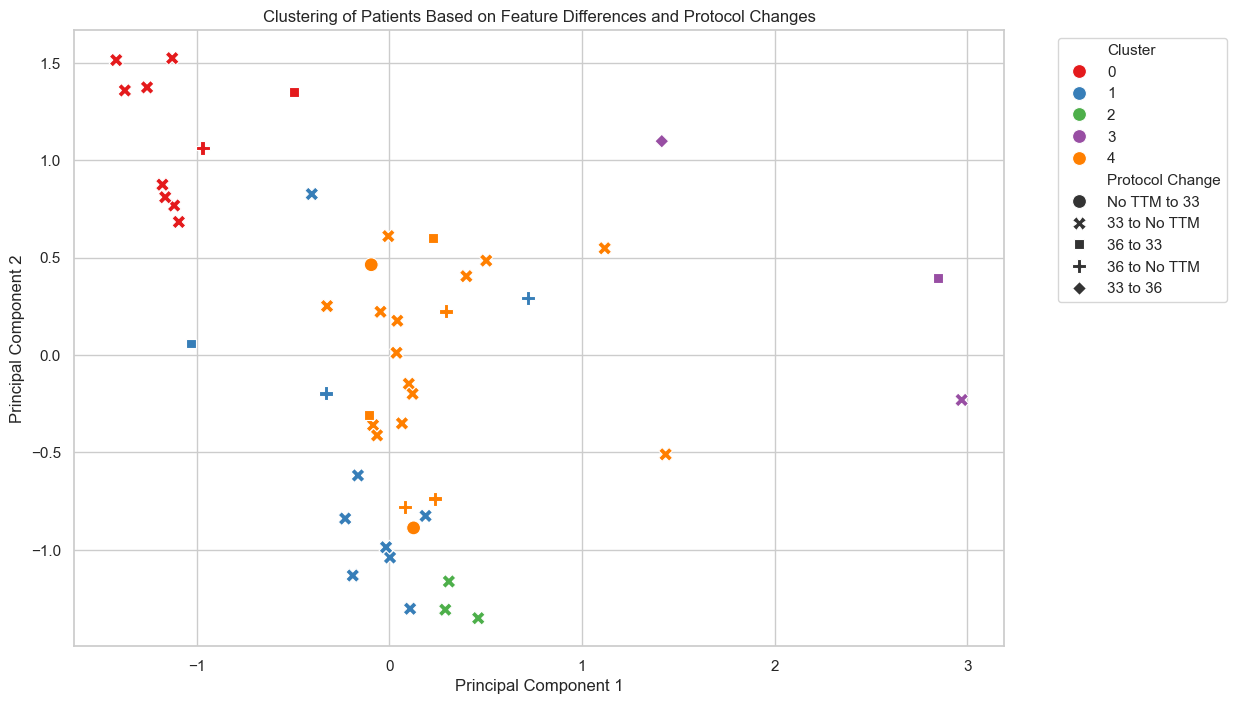

In [24]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude 'Original_TTM' and 'Best_Prediction' from the data used for clustering
data_for_clustering_cleaned = data_for_clustering.drop(columns=['Original_TTM', 'Best_Prediction'])

# Step 5: Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering_cleaned)

# Step 6: Add cluster labels to the DataFrame for analysis
changed_protocol_df['Cluster'] = clusters

# Step 7: Apply PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_for_clustering_cleaned)

# Step 8: Create a DataFrame with PCA results and cluster labels for plotting
pca_df = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['Protocol Change'] = changed_protocol_df['Original_TTM'] + ' to ' + changed_protocol_df['Best_Prediction']

# Step 9: Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', style='Protocol Change', data=pca_df, palette="Set1", s=100)
plt.title('Clustering of Patients Based on Feature Differences and Protocol Changes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [27]:
pca_df

,PCA1,PCA2,Cluster,Protocol Change
0,-1.814433,1.273473,0,NaN
1,0.125718,-0.887612,4,No TTM to 33
2,0.386688,-0.384344,4,NaN
3,0.107814,-1.302861,1,33 to No TTM
4,1.433784,-0.510001,4,33 to No TTM
...,...,...,...,...
157,-1.163138,0.810597,0,33 to No TTM
158,-0.017131,-0.986885,1,33 to No TTM
159,-1.074826,-0.443078,2,NaN
160,-1.127544,1.519380,0,NaN


In [19]:
merged_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,...,Patient_ID,outcome,Original_TTM,Avg_Mean_HR,Avg_SDNN_HRV,Avg_LF_HF_Ratio,Pred_TTM_33,Pred_TTM_36,Pred_No_TTM,Best_Prediction
0,284,-0.522787,False,True,True,False,True,False,False,False,...,284,1,33,0.344114,-0.001518,-0.025960,0.460305,0.466902,0.470689,33
1,286,1.525272,True,False,False,False,False,False,True,True,...,286,1,No TTM,-0.106849,0.221049,-0.042867,0.653342,0.620690,0.625586,33
2,296,-0.842797,False,True,True,False,False,True,False,False,...,296,1,36,0.013657,0.007461,-0.063472,0.476538,0.494961,0.502178,36
3,299,-1.034802,False,True,True,False,True,False,False,False,...,299,1,33,-0.033315,0.078566,-0.025428,0.445127,0.461137,0.465213,No TTM
4,303,-0.650791,False,True,True,False,True,False,False,False,...,303,1,33,0.001747,0.072794,-0.024249,0.469148,0.496695,0.502552,No TTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,True,False,False,True,...,1016,0,33,-0.279062,0.835295,-0.193231,0.614046,0.588466,0.592818,33
603,1017,-2.250837,False,True,True,False,False,False,True,True,...,1017,0,No TTM,0.000000,0.000000,0.000000,0.481191,0.503264,0.497975,No TTM
604,1018,0.117231,False,True,True,False,False,True,False,False,...,1018,0,36,0.641675,-0.461834,-0.085916,0.522869,0.521467,0.521849,36
605,1019,0.693248,False,True,True,False,False,True,False,False,...,1019,1,36,-0.114331,0.001234,-0.016844,0.524827,0.514159,0.532437,36


In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd

# Define the features for clustering (excluding TTM protocol columns)
features_for_clustering = [col for col in tabular_cols if col not in ['ttm_33.0', 'ttm_36.0', 'ttm_No TTM']]

# Prepare the data for clustering: Select relevant rows and features (without additional scaling)
data_for_clustering = changed_protocol_df[features_for_clustering].values

# Perform hierarchical clustering using the "ward" method
linkage_matrix = linkage(data_for_clustering, method='ward')

# Ensure labels match the number of samples
labels = (changed_protocol_df['Original_TTM'] + ' to ' + changed_protocol_df['Best_Prediction']).tolist()

if len(labels) != data_for_clustering.shape[0]:
    raise ValueError("The number of labels does not match the number of data points in the linkage matrix.")

# Plot the dendrogram with correct label length
plt.figure(figsize=(120, 80))
dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Hierarchical Clustering (Excluding TTM Protocol Columns)")
plt.xlabel("Patients (Protocol Change)")
plt.ylabel("Distance")
plt.show()
